# 1. Import libraries and dataset

## Import dataset from google drive

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1t4GfxnNQr4BDD8Ob6TpuhvkiInLn2iaW'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('FinalBalancedDataset.csv')

## Import libraries

In [27]:
!pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 974 kB 5.1 MB/s 


In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
import re
from nltk.stem.porter import *
from tqdm import tqdm
from copy import deepcopy
from glove import Glove, Corpus
import pandas as pd
import string
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import torch
from torch.optim import AdamW, Adam
from torch.nn import BCELoss
import torch.nn as nn
from torchsummary import summary
from torch.autograd import Variable
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset

In [4]:
df = pd.read_csv('FinalBalancedDataset.csv')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data pre-processing

## Data information

In [6]:
df.head(5)

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56745 non-null  int64 
 1   Toxicity    56745 non-null  int64 
 2   tweet       56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


## Data pre-processing

Seems like this dataset doesnt need to do anything...

In [21]:
def clean_text(tweet):
    sent = []
    for text in tqdm(tweet):
        text = str(text).lower()
        text = re.sub(r'(\<(/?[^>]+)>)', '', text)
        text = re.sub(r'\.{2,}', ' ', text)
        text = re.sub(r'user', ' ', text)
        regex = re.compile('[^a-zA-Z]')
        text = regex.sub(' ', text)
        text = [word.strip(string.punctuation) for word in text.split(" ")]
        text = [word for word in text if not any(c.isdigit() for c in word)]
        stop = stopwords.words('english')
        text = [x for x in text if x not in stop]
#         text = [t for t in text if len(t) > 0]
        text = [t for t in text if len(t) > 1]
#         text = [lemmatizer.lemmatize(each_word) for each_word in text]
        sent.append(text)
    return sent

In [17]:
df.drop('Unnamed: 0', axis=1, inplace = True)

In [22]:
corpus_sent = clean_text(df.tweet)

100%|██████████| 56745/56745 [00:12<00:00, 4463.30it/s]


In [29]:
corpus = Corpus()
corpus.fit(corpus=corpus_sent, window=5)
glove = Glove(no_components=300,
             learning_rate=0.05,
             random_state=1,
             max_count=100,
             alpha=0.75)
glove.fit(corpus.matrix, epochs=10, no_threads=4, verbose=True)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [30]:
glove.add_dictionary(corpus.dictionary)

In [31]:
def mean_vec_sent(corpus_sent, model_emb, labels):
    embed_list = []
    labels_list = []
    for sent_id, tokens_sent in tqdm(enumerate(corpus_sent), total=len(corpus_sent)):
        words = [*filter(lambda word: word in model_emb.dictionary.keys(), tokens_sent)]
        if words:
            embeds = [glove.word_vectors[glove.dictionary[x]] for x in words]
            embed_list.append(np.mean(embeds, axis=0))
            labels_list.append(labels[sent_id])
    assert len(embed_list) == len(labels_list)
    return np.array(embed_list), labels_list

In [32]:
labels = df.Toxicity
emb_list, labels_list = mean_vec_sent(corpus_sent, glove, labels)

100%|██████████| 56745/56745 [00:03<00:00, 17750.38it/s]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(emb_list, labels_list, stratify=labels_list, test_size=0.25)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
batch_size = 64

train_dataloader = DataLoader(train_dataset,
                              sampler=SequentialSampler(train_dataset),
                              batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size)

## Glove

In [36]:
class MODEL_classifier(nn.Module):
    def __init__(self, emb_size=300):     
        super(MODEL_classifier, self).__init__()
        self.Linear1 = nn.Linear(emb_size, 64)
        self.bn128 = nn.BatchNorm1d(64)
        self.Activation1 = nn.ReLU()
        self.Dropout1 = nn.Dropout(p=0.2)
        self.Dropout2 = nn.Dropout(p=0.2)
        self.Linear2 = nn.Linear(64, 32)
        self.bn32 = nn.BatchNorm1d(32)
        self.Activation2 = nn.ReLU()
        self.Linear3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.kaiming_uniform_(self.Linear1.weight)
        nn.init.kaiming_uniform_(self.Linear2.weight)
        nn.init.kaiming_uniform_(self.Linear3.weight)

    def forward(self, x):
        x = self.Linear1(x)
        x = self.bn128(x)
        x = self.Activation1(x)
        x = self.Dropout1(x)
        x = self.Linear2(x)
        x = self.bn32(x)
        x = self.Activation2(x)
        x = self.Dropout2(x)
        x = self.Linear3(x)
        x = self.sigmoid(x)
        return x

In [37]:
def train(train_dataloader, val_dataloader, model, loss_fn, optimizer, epoch, device, type_train='multilabel'):
    losses_train_mean = []
    losses_val_mean = []
    acc_train_mean = []
    acc_val_mean = []
    f1_train_mean = []
    f1_val_mean = []
    print('start training model classifier')
    for i in tqdm(range(epoch)):
        loss_train = []
        loss_val = []
        acc_train = []
        acc_val = []
        f1_train = []
        f1_val = []
        model.train()
        for d in train_dataloader:
            X_train = d[0].to(device).float()
            optimizer.zero_grad()
            preds_train = model(X_train)
            if type_train == 'multilabel':
                y_train = torch.tensor(d[1].to(device), dtype=torch.long)
                _, y_pred = torch.max(preds_train, dim=1)
                f1_train.append(f1_score(y_pred.cpu().numpy(), y_train.cpu().numpy(), average='weighted'))
                acc_train.append(accuracy_score(y_pred.cpu().numpy(), y_train.cpu().numpy()))
                loss_t = loss_fn(preds_train, y_train)
            elif type_train == 'binary':
                y_train = d[1].to(device).float()
                y_pred = [1. if tmp > 0.5 else 0 for tmp in preds_train.cpu().detach().numpy()]
                f1_train.append(f1_score(y_pred, y_train.cpu().numpy()))
                acc_train.append(accuracy_score(y_pred, y_train.cpu().numpy()))
                loss_t = loss_fn(preds_train, torch.unsqueeze(y_train, 1))
            loss_train.append(loss_t.item())
            loss_t.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            optimizer.zero_grad()
            for d_v in val_dataloader:
                X_val = d_v[0].to(device).float()
                preds_val = model(X_val)
                if type_train == 'multilabel':
                    y_val = torch.tensor(d_v[1].to(device), dtype=torch.long)
                    _, y_pred_v = torch.max(preds_val, dim=1)
                    f1_val.append(f1_score(y_pred_v.cpu().numpy(), y_val.cpu().numpy(), average='weighted'))
                    acc_val.append(accuracy_score(y_pred_v.cpu().numpy(), y_val.cpu().numpy()))
                    loss_v = loss_fn(preds_val, y_val)
                elif type_train == 'binary':
                    y_val = d_v[1].to(device).float()
                    y_pred_v = [1. if tmp > 0.5 else 0 for tmp in preds_val.cpu().detach().numpy()]
                    f1_val.append(f1_score(y_pred_v, y_val.cpu().numpy()))
                    acc_val.append(accuracy_score(y_pred_v, y_val.cpu().numpy()))
                    loss_v = loss_fn(preds_val, torch.unsqueeze(y_val, 1))
                loss_val.append(loss_v.item())
        if i % 2 == 0:
            print('---Train---')
            print('Epoch: {}, Accuracy: {}, F1_score: {}, Loss: {}'.format(i, np.mean(acc_train), np.mean(f1_train), np.mean(loss_train)))
            print('---Validation---')
            print('Epoch: {}, Accuracy: {}, F1_score: {}, Loss: {}'.format(i, np.mean(acc_val), np.mean(f1_val), np.mean(loss_val)))
        acc_train_mean.append(np.mean(acc_train))
        acc_val_mean.append(np.mean(acc_val))
        losses_train_mean.append(np.mean(loss_train))
        losses_val_mean.append(np.mean(loss_val))
        f1_train_mean.append(np.mean(f1_train))
        f1_val_mean.append(np.mean(f1_val))
    print('training model classifier finished')
    return {'loss_train': losses_train_mean, 'loss_val': losses_val_mean, 
            'acc_train': acc_train_mean, 'acc_val': acc_val_mean,
            'f1_train': f1_train_mean, 'f1_val': f1_val_mean}

In [38]:
def learning_curves(dct_history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
#     plt.figure(figsize=(8,6))
    keys = ['loss', 'acc', 'f1']
    for idx, ax in enumerate(fig.axes):
        train = dct_history[f'{keys[idx]}_train']
        val = dct_history[f'{keys[idx]}_val']
        ax.plot(range(1, len(train)+1), train, label=f'{keys[idx]}_train')
        ax.plot(range(1, len(val)+1), val, label=f'{keys[idx]}_val')
        ax.set_title('Training history', fontsize=12)
        ax.set_ylabel(f'{keys[idx]}', fontsize=12)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.legend(fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid()
    plt.show()


In [50]:
def compute_score(metrics_, model_name):
    metrics_temp = deepcopy(metrics_)
    dct_info = {'loss_train': [], 'loss_val': [], 'acc_train': [], 'acc_val': [], 'f1_train': [], 'f1_val': []}
    for idx in dct_info.keys():
        dct_info[idx].append(metrics_temp[idx][-1])
    dct_info['model'] = model_name
    return dct_info

In [41]:
model_classifier = MODEL_classifier(300).to(device)
optimizer = Adam(model_classifier.parameters(), lr=0.0001)
loss_fn = BCELoss()

In [44]:
summary(model_classifier, (300,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          19,264
       BatchNorm1d-2                   [-1, 64]             128
              ReLU-3                   [-1, 64]               0
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
       BatchNorm1d-6                   [-1, 32]              64
              ReLU-7                   [-1, 32]               0
           Dropout-8                   [-1, 32]               0
            Linear-9                    [-1, 1]              33
          Sigmoid-10                    [-1, 1]               0
Total params: 21,569
Trainable params: 21,569
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Tot

In [47]:
EPOCH = 30
dct_history = train(train_dataloader, val_dataloader, model_classifier, loss_fn, optimizer, EPOCH, device, 'binary')

start training model classifier


  3%|▎         | 1/30 [00:03<01:34,  3.25s/it]

---Train---
Epoch: 0, Accuracy: 0.8395940134426977, F1_score: 0.7950759476477346, Loss: 0.3831437836688264
---Validation---
Epoch: 0, Accuracy: 0.8681238056238056, F1_score: 0.8326421019467871, Loss: 0.318430728874765


 10%|█         | 3/30 [00:09<01:25,  3.17s/it]

---Train---
Epoch: 2, Accuracy: 0.8674121383002963, F1_score: 0.8359883556261775, Loss: 0.3204323542073257
---Validation---
Epoch: 2, Accuracy: 0.875725156975157, F1_score: 0.8446990292065046, Loss: 0.2974032221345214


 17%|█▋        | 5/30 [00:16<01:21,  3.26s/it]

---Train---
Epoch: 4, Accuracy: 0.8709145021645023, F1_score: 0.8407455384836787, Loss: 0.31005693748033136
---Validation---
Epoch: 4, Accuracy: 0.8777662605787605, F1_score: 0.847667421171705, Loss: 0.29145350850917195


 23%|██▎       | 7/30 [00:23<01:21,  3.53s/it]

---Train---
Epoch: 6, Accuracy: 0.872064393939394, F1_score: 0.8423358800390464, Loss: 0.30748887911326905
---Validation---
Epoch: 6, Accuracy: 0.8798734814359814, F1_score: 0.8496912800949165, Loss: 0.2886932209671081


 30%|███       | 9/30 [00:33<01:24,  4.04s/it]

---Train---
Epoch: 8, Accuracy: 0.8739440931875143, F1_score: 0.8445423878021122, Loss: 0.30325399184585516
---Validation---
Epoch: 8, Accuracy: 0.8797369812994813, F1_score: 0.8505575509953364, Loss: 0.2873622595189928


 37%|███▋      | 11/30 [00:39<01:08,  3.60s/it]

---Train---
Epoch: 10, Accuracy: 0.8749088630667579, F1_score: 0.8456299972638549, Loss: 0.30163831385902895
---Validation---
Epoch: 10, Accuracy: 0.8817780849030848, F1_score: 0.8516615257596517, Loss: 0.2855628652347101


 43%|████▎     | 13/30 [00:46<00:57,  3.38s/it]

---Train---
Epoch: 12, Accuracy: 0.8751908179539759, F1_score: 0.8458671288692817, Loss: 0.300680308301646
---Validation---
Epoch: 12, Accuracy: 0.8824861793611793, F1_score: 0.8526242477207102, Loss: 0.2837818826775293


 50%|█████     | 15/30 [00:54<00:55,  3.70s/it]

---Train---
Epoch: 14, Accuracy: 0.8766226646160857, F1_score: 0.8476205845111249, Loss: 0.29784129938684906
---Validation---
Epoch: 14, Accuracy: 0.8824115308490308, F1_score: 0.854110720265674, Loss: 0.28157605620117876


 57%|█████▋    | 17/30 [01:00<00:44,  3.39s/it]

---Train---
Epoch: 16, Accuracy: 0.8771879984051038, F1_score: 0.8480112537403159, Loss: 0.29702879006701305
---Validation---
Epoch: 16, Accuracy: 0.8836784227409227, F1_score: 0.8540465089331266, Loss: 0.27995536667672366


 63%|██████▎   | 19/30 [01:06<00:35,  3.26s/it]

---Train---
Epoch: 18, Accuracy: 0.878315817953976, F1_score: 0.8493094735473601, Loss: 0.29560837501421905
---Validation---
Epoch: 18, Accuracy: 0.8819231162981163, F1_score: 0.852489046293081, Loss: 0.27991488112791163


 70%|███████   | 21/30 [01:13<00:28,  3.19s/it]

---Train---
Epoch: 20, Accuracy: 0.8770925894281157, F1_score: 0.8477528035789945, Loss: 0.29447216433017775
---Validation---
Epoch: 20, Accuracy: 0.8835419226044225, F1_score: 0.8538570380357823, Loss: 0.2780840651946025


 77%|███████▋  | 23/30 [01:19<00:22,  3.16s/it]

---Train---
Epoch: 22, Accuracy: 0.878785742766006, F1_score: 0.8500117975206725, Loss: 0.2912424275189414
---Validation---
Epoch: 22, Accuracy: 0.8843118686868686, F1_score: 0.8577890655304874, Loss: 0.279033453212128


 83%|████████▎ | 25/30 [01:25<00:15,  3.14s/it]

---Train---
Epoch: 24, Accuracy: 0.8786682615629985, F1_score: 0.8497770048886489, Loss: 0.29237464490465653
---Validation---
Epoch: 24, Accuracy: 0.885860292110292, F1_score: 0.8571031834334709, Loss: 0.2756381419797738


 90%|█████████ | 27/30 [01:31<00:09,  3.12s/it]

---Train---
Epoch: 26, Accuracy: 0.8799121383002962, F1_score: 0.8513153315751768, Loss: 0.2905570433552104
---Validation---
Epoch: 26, Accuracy: 0.8864233551733551, F1_score: 0.857936186239417, Loss: 0.27629379277025257


 97%|█████████▋| 29/30 [01:38<00:03,  3.11s/it]

---Train---
Epoch: 28, Accuracy: 0.8798416495784918, F1_score: 0.8508719691020348, Loss: 0.29070104985756984
---Validation---
Epoch: 28, Accuracy: 0.8850156975156975, F1_score: 0.8564798319428715, Loss: 0.2751564939951037


100%|██████████| 30/30 [01:41<00:00,  3.37s/it]

training model classifier finished


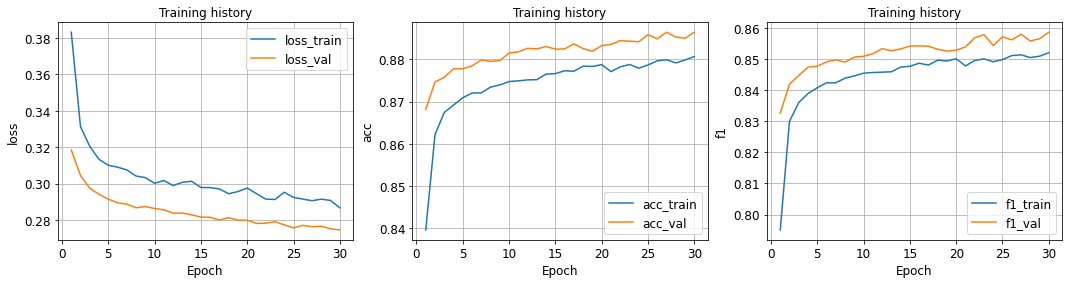

In [48]:
learning_curves(dct_history)

In [53]:
dct_score_glove = compute_score(dct_history, 'glove_own_training')

In [54]:
dct_score_glove

{'loss_train': [0.2866623647230908],
 'loss_val': [0.2745149134918376],
 'acc_train': [0.8806654420141263],
 'acc_val': [0.8864233551733551],
 'f1_train': [0.8519780645584474],
 'f1_val': [0.8585606591172299],
 'model': 'glove_own_training'}